In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import os

%matplotlib inline
warnings.filterwarnings('ignore')

plt.rcParams['font.family'] = 'NanumGothic'

import tensorflow as tf
gpu = tf.config.experimental.list_physical_devices('GPU') # 내 컴에 장착된 GPU를 list로 반환
try:
    tf.config.experimental.set_memory_growth(gpu[0], True) # GPU Memory Growth를 Enable
except RuntimeError as e:
    print(e) # Error 발생하면 Error 내용 출력

In [2]:
path ='C:/project/전력'
file_list = os.listdir(path)
# 텍스트 파일만 추출
file_list_txt = [file for file in file_list if file.endswith('txt')]
date = []
power = []
count = 0
for i in range(len(file_list_txt)):
    
    file = open(file_list_txt[i]).read().splitlines()
    del file[:2]
    if (len(file) == 24):
        
        data_clean = []
        daily_date = []
        daily_power = []
        for j in range(len(file)):
            line = file[j].split(sep=' ')
            data_clean.append(line)
            daily_date.append(data_clean[j][0]+' '+data_clean[j][1])
            daily_power.append(data_clean[j][-1])
        for k in range(len(daily_power)):
            daily_power[k] = daily_power[k].replace(")","")
            daily_power[k] = int(daily_power[k])
        date.append(daily_date)
        power.append(daily_power)
    else:
        pass
date = sum(date, [])
power = sum(power, [])

# # 판다스로 변환
# edf_col_name = ['date', 0]
# edf = pd.DataFrame([x for x in zip(date, power)], columns = edf_col_name)
# # 날짜 컬럼으로 인덱스 대체하기
# edf = edf.set_index("date")
# edf[0]=edf[0].apply(float)

date = np.array(date)
power = np.array(power)
# date = date.reshape(len(date), 1)
power = power.reshape(len(date), 1)


In [3]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
# 스케일을 적용할 column을 정의합니다.
# 스케일 후 columns
power = scaler.fit_transform(power)
power = power.reshape(-1,)

In [4]:
split_time = 30000

date_train = date[:split_time]
date_valid = date[split_time:]

x_train = power[:split_time]
x_valid = power[split_time:]

In [5]:
x_valid.shape, date_valid.shape

((7296,), (7296,))

In [6]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)

In [7]:
window_size=1200
batch_size=50
shuffle_size = 1000

In [8]:
train_set = windowed_dataset(x_train, 
                             window_size=window_size, 
                             batch_size=batch_size,
                             shuffle_buffer=shuffle_size)

validation_set = windowed_dataset(x_valid, 
                                  window_size=window_size,
                                  batch_size=batch_size,
                                  shuffle_buffer=shuffle_size)

In [9]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Conv1D, Lambda
from tensorflow.keras.losses import Huber
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


In [20]:
model = Sequential([
    tf.keras.layers.Conv1D(60, kernel_size=5,
                         padding="causal",
                         activation="relu",
                         input_shape=[None, 1]),
    tf.keras.layers.LSTM(60, return_sequences=True),
    tf.keras.layers.LSTM(60, return_sequences=True),
    tf.keras.layers.Dense(30, activation="relu"),
    tf.keras.layers.Dense(10, activation="relu"),
    tf.keras.layers.Dense(1),
    tf.keras.layers.Lambda(lambda x: x * 400)
])

In [21]:
# Sequence 학습에 비교적 좋은 퍼포먼스를 내는 Huber()를 사용합니다.
loss = Huber()
optimizer = Adam(0.0005)
model.compile(loss=Huber(), optimizer=optimizer, metrics=['mse'])

In [22]:

earlystopping = EarlyStopping(monitor='val_loss', patience=10)

filename = os.path.join('tmp', 'ckeckpointer.ckpt')
checkpoint = ModelCheckpoint(filename, 
                             save_weights_only=True, 
                             save_best_only=True, 
                             monitor='val_loss', 
                             verbose=1)

In [23]:
history = model.fit(train_set, 
                    validation_data=(validation_set), 
                    epochs=50, 
                    callbacks=[checkpoint, earlystopping])

Epoch 1/50
    576/Unknown - 122s 212ms/step - loss: 0.0140 - mse: 0.0307
Epoch 00001: val_loss improved from inf to 0.00988, saving model to tmp\ckeckpointer.ckpt
576/576 [==============================] - 138s 239ms/step - loss: 0.0140 - mse: 0.0307 - val_loss: 0.0099 - val_mse: 0.0198
Epoch 2/50
576/576 [==============================] - ETA: 0s - loss: 0.0101 - mse: 0.0202
Epoch 00002: val_loss improved from 0.00988 to 0.00966, saving model to tmp\ckeckpointer.ckpt
576/576 [==============================] - 139s 241ms/step - loss: 0.0101 - mse: 0.0202 - val_loss: 0.0097 - val_mse: 0.0193
Epoch 3/50
576/576 [==============================] - ETA: 0s - loss: 0.0098 - mse: 0.0195
Epoch 00003: val_loss improved from 0.00966 to 0.00947, saving model to tmp\ckeckpointer.ckpt
576/576 [==============================] - 152s 264ms/step - loss: 0.0098 - mse: 0.0195 - val_loss: 0.0095 - val_mse: 0.0189
Epoch 4/50
576/576 [==============================] - ETA: 0s - loss: 0.0096 - mse: 0.0192


Epoch 30/50
576/576 [==============================] - ETA: 0s - loss: 0.0079 - mse: 0.0159
Epoch 00030: val_loss did not improve from 0.00853
576/576 [==============================] - 118s 205ms/step - loss: 0.0079 - mse: 0.0159 - val_loss: 0.0087 - val_mse: 0.0174
Epoch 31/50
576/576 [==============================] - ETA: 0s - loss: 0.0079 - mse: 0.0158
Epoch 00031: val_loss did not improve from 0.00853
576/576 [==============================] - 126s 219ms/step - loss: 0.0079 - mse: 0.0158 - val_loss: 0.0088 - val_mse: 0.0176
Epoch 32/50
576/576 [==============================] - ETA: 0s - loss: 0.0079 - mse: 0.0157
Epoch 00032: val_loss did not improve from 0.00853
576/576 [==============================] - 118s 205ms/step - loss: 0.0079 - mse: 0.0157 - val_loss: 0.0091 - val_mse: 0.0182
Epoch 33/50
576/576 [==============================] - ETA: 0s - loss: 0.0078 - mse: 0.0157
Epoch 00033: val_loss did not improve from 0.00853
576/576 [==============================] - 121s 210ms

In [27]:
model.load_weights(filename)

In [28]:
pred = model.predict(validation_set)

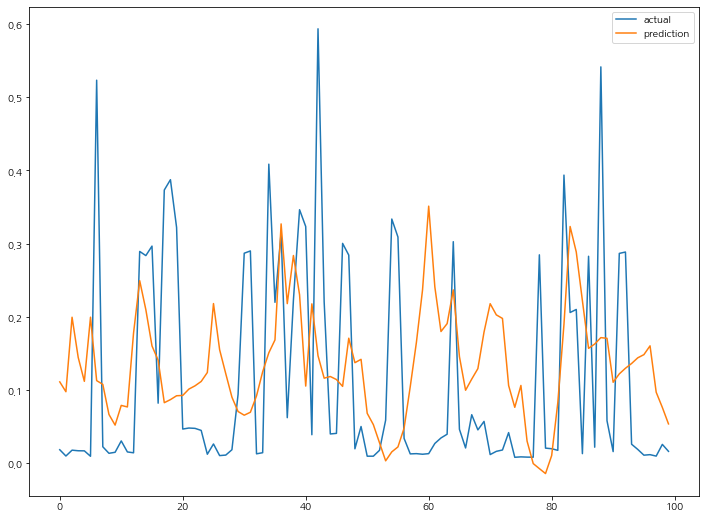

In [31]:
plt.figure(figsize=(12, 9))
plt.plot(x_valid[:100], label='actual')
plt.plot(pred[0, :100], label='prediction')
plt.legend()
plt.show()